In [21]:
import math
import time

import matplotlib.pyplot as plt
import torch
from diffusers import DDIMScheduler

from functionalities import generate
from miscellaneous import utilities

# Select config experiments
BASE_PATH = "model_weights/DDIM_128"

########## SETTING THINGS UP #########
device = utilities.set_device()
print(f"Device used: {device}.")

# Initialize denoiser and generator
G = generate.Generator(base_path=BASE_PATH)
eps = G.eps

# Set schedule timesteps
scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
)

Device used: cuda.


## Step 0
Check that $\alpha_0 = 1$, $\alpha_T \approx 0$.

In [32]:
# Get {alpha_t} from scheduler
alphas = scheduler.alphas_cumprod

print(r"alpha_0 =", alphas[0].item())
print(r"alpha_T =", alphas[-1].item())

alpha_0 = 0.9998999834060669
alpha_T = 4.0358307160204276e-05


## Step 1
We show that $Var(\epsilon_\theta(x_{t + \delta t}, t + \delta t)) = I$ as we expect as $\epsilon_\theta(x_t, t) \approx \epsilon_t$.

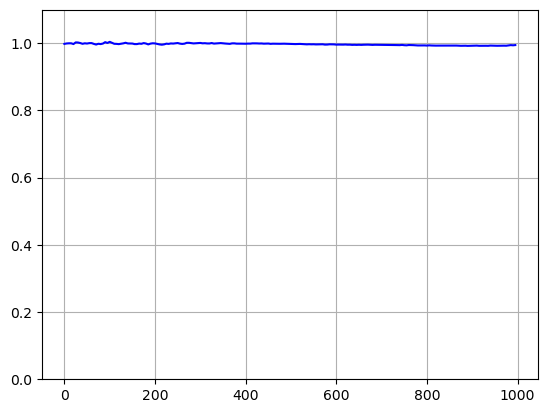

In [20]:
# Define number of timesteps
N = 200
scheduler.set_timesteps(num_inference_steps=N)

# Get random seed
x_t = torch.randn((5, 1, 128, 128), device=device)

# Reverse diffusion loop
var_t = torch.zeros((N, )) # initialize variance vector
for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        # Predict noise
        eps_t = eps(x_t, t)
        
        # Get diffusion step
        x_t = scheduler.step(eps_t, t, x_t).prev_sample

        # Get variance of predicted noise
        v_t = torch.var(eps_t, dim=0).squeeze(0)

        # Save it
        var_t[i] = v_t.mean()

# Plotting
plt.plot(scheduler.timesteps, var_t.cpu(), 'b-')
plt.ylim((0, 1.1))
plt.grid()
plt.show()

## Step 2
Since:

$$
x_t = \sqrt{\alpha_t} x_0 + \sqrt{1 - \alpha_t} \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, I),
$$

then:

$$
\mathbb{E} [x_t] = \sqrt{\alpha_t} \mathbb{E} [x_0] + \sqrt{1 - \alpha_t} \underbrace{\mathbb{E} [\epsilon_t]}_{=0} = \sqrt{\alpha_t} \mathbb{E} [x_0],
$$

from which:

$$
\mathbb{E} [x_0] = \frac{\mathbb{E} [x_t]}{\sqrt{\alpha_t}}.
$$

Therefore, we expect the ratio on the right-hand side to be constant, and this constant is equal to $\mathbb{E} [x_0]$.

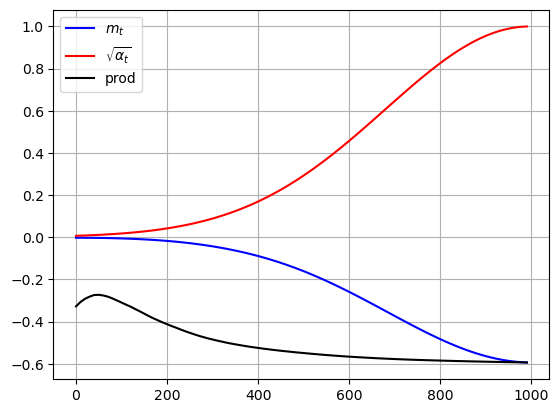

In [64]:
# Define number of timesteps
N = 100
scheduler.set_timesteps(num_inference_steps=N)

# Get random seed
x_t = torch.randn((5, 1, 128, 128), device=device)

# Reverse diffusion loop
mean_t = torch.zeros((N, )) # initialize mean vector
res = torch.zeros((N, )) # initialize variance vector
for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        # Predict noise
        eps_t = eps(x_t, t)
        
        # Get mean of predicted noise
        m_t = torch.mean(x_t)

        # Save it
        mean_t[i] = m_t
        res[i] = m_t / (torch.sqrt(alphas[t]))

        # Get diffusion step
        x_t = scheduler.step(eps_t, t, x_t).prev_sample


# Plotting
plt.plot(list(scheduler.timesteps)[::-1], mean_t.cpu(), 'b-')
plt.plot(list(scheduler.timesteps)[::-1], torch.sqrt(alphas[scheduler.timesteps]), 'r-')
plt.plot(list(scheduler.timesteps)[::-1], res, 'k-')
plt.legend([r"$m_t$", r"$\sqrt{\alpha_t}$", "prod"])
plt.grid()
plt.show()

## Step 3
We want to compute the element-wise covariance, defined as:

$$
Cov(x_t^{(i)}, \epsilon_\theta(x_t, t)^{(i)})
$$

where:

$$
Cov(a, b) = \mathbb{E}[ab] - \mathbb{E}[a]\mathbb{E}[b]
$$

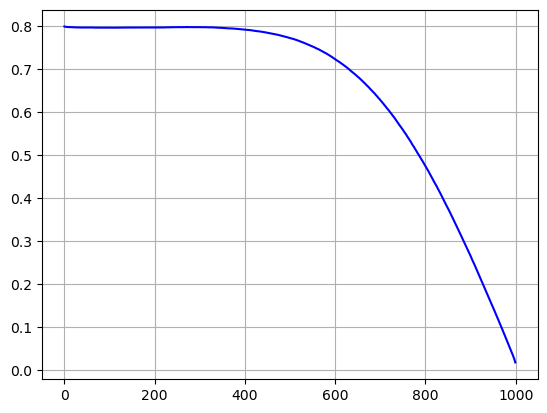

In [67]:
# Define number of timesteps
N = 1000
scheduler.set_timesteps(num_inference_steps=N)

# Get random seed
x_t = torch.randn((5, 1, 128, 128), device=device)

# Reverse diffusion loop
cov_t = torch.zeros((N, )) # initialize covariance vector
for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        # Predict noise
        eps_t = eps(x_t, t)
        
        # Get covariance
        c_t = torch.mean(x_t*eps_t, dim=0) - torch.mean(x_t, dim=0)*torch.mean(eps_t, dim=0)
        cov_t[i] = c_t.mean()

        # Get diffusion step
        x_t = scheduler.step(eps_t, t, x_t).prev_sample

# Plotting
plt.plot(list(scheduler.timesteps)[::-1], cov_t.cpu(), 'b-')
plt.grid()
plt.show()

And, similarly, check:

$$
Cov(x_t^{(i)}, x_t^{(j)}),
$$

for different $i, j$.

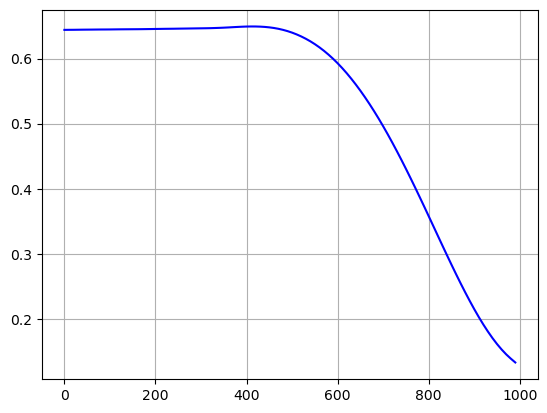

In [68]:
# Define number of timesteps
N = 100
scheduler.set_timesteps(num_inference_steps=N)

# Get random seed
x_t = torch.randn((5, 1, 128, 128), device=device)

# Set indices (ix, iy), (jx, jy) 
ix, iy = 30, 30
jx, jy = 30, 31

# Reverse diffusion loop
cov_t = torch.zeros((N, )) # initialize covariance vector
for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        # Predict noise
        eps_t = eps(x_t, t)
        
        # Get covariance
        c_t = torch.mean(x_t[:, :, ix, iy]*x_t[:, :, jx, jy], dim=0) - torch.mean(x_t[:, :, ix, iy], dim=0)*torch.mean(x_t[:, :, jx, jy], dim=0)
        cov_t[i] = c_t

        # Get diffusion step
        x_t = scheduler.step(eps_t, t, x_t).prev_sample

# Plotting
plt.plot(list(scheduler.timesteps)[::-1], cov_t.cpu(), 'b-')
plt.grid()
plt.show()

## Step 4:
Test approximation for the independent step, i.e. when

$$
Var(f_t x_t + g_t \epsilon(x_t, t)) = f_t^2 Var(x_t) + g_t^2 Var(\epsilon(x_t, t))
$$

In [74]:
# Define number of timesteps
N = 100
scheduler.set_timesteps(num_inference_steps=N)

alpha_t = alphas[scheduler.timesteps]

# Define f_t and g_t
f_t = torch.zeros((N, ))
g_t = torch.zeros((N, ))
for i, t in enumerate(scheduler.timesteps):
    f_t[i] = torch.sqrt(alpha_t[i] / alpha_t[i+1])
    g_t[i] = torch.sqrt(1 - alpha_t[i]) - torch.sqrt(alpha_t[i] / alpha_t[i+1]) * torch.sqrt(1 - alpha_t[i+1])

# Compute c_t
c_t = torch.zeros((N, ))
for i, t in enumerate(scheduler.timesteps-1):
    for m in range(i):
        prod_fn = 1
        for k in range(m+1):
            prod_fn = prod_fn * f_t[k]
        c_t[i] = c_t[i] + g_t[m] / prod_fn

# Predicted variances
pred_variances = torch.zeros((N, ))
for i, t in enumerate(scheduler.timesteps):
    pred_variances[i] = torch.cumprod(f_t, dim=0)[i] * (1 + c_t[i])

# Plotting
plt.plot(pred_variances, 'b-')
plt.grid()
plt.show()

IndexError: index 100 is out of bounds for dimension 0 with size 100